# Espinardo Fluo 5b

#### Measurements JMB paper

- Calibration measurement

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [2]:
from IPython.display import Image as IM
from IPython.display import Math
from IPython.display import Latex

In [3]:
from PIL import Image, ImageFilter
from functools import reduce

In [4]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Fri May 31 13:12:48 2019


In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from sabat.sbt_espinardo import get_jpeg_dirs
from sabat.sbt_espinardo import get_files
from sabat.sbt_espinardo import read_xls_files
from sabat.sbt_espinardo import sort_by_list
from sabat.sbt_espinardo import sort_files
from sabat.sbt_espinardo import load_LIVE_images
from sabat.sbt_espinardo import expo_seed
from sabat.sbt_espinardo import  get_live_dirs
from sabat.sbt_espinardo import get_profile
from sabat.sbt_espinardo import display_profile
from sabat.sbt_espinardo import display_profiles_before_after
from sabat.sbt_espinardo import plot_LIVE_images
from sabat.sbt_espinardo import plot_LIVE_avg
from sabat.sbt_espinardo import plot_avg_intensity
from sabat.sbt_espinardo import plot_total_intensity
from sabat.sbt_espinardo import avg_intensity
from sabat.sbt_espinardo import total_intensity
from sabat.sbt_espinardo import plot_TOM

from sabat.sbt_espinardo import get_TOM_files
from sabat.sbt_espinardo import display_profiles
from sabat.sbt_espinardo import show_toms
from sabat.sbt_espinardo import mean_and_std_toms
from sabat.sbt_espinardo import tom_I, tom_mean_I

In [7]:
from  invisible_cities.core.system_of_units import *

In [8]:
import invisible_cities.core .fit_functions  as     fitf

In [9]:
from sabat.sbt_types import FoV, CircularFoV, Monolayer
from sabat.sbt_types import Laser, PulsedLaser, GLaser, GaussianBeam
from sabat.sbt_types import Molecule
from sabat.sbt_types import Molecule2P
from sabat.sbt_types import DyeSample
from sabat.sbt_types import Microscope
from sabat.sbt_types import CCD
from sabat.sbt_core import  Setup
from sabat.sbt_core import  power_density
from sabat.sbt_core import  photon_density
from sabat.sbt_core import  fluorescence_per_molecule
from sabat.sbt_core import  duration_of_fluorescence
from sabat.sbt_core import  diffraction_limit
from sabat.sbt_core import  photoelectrons_per_pixel
from sabat.sbt_core import  fluorescence_2p_gb
from sabat.sbt_core import  fluorescence_2p_dl
from sabat.sbt_core import  absorbed_photons_per_fluorophore_per_pulse_2p
from sabat.sbt_types import  photon, molecule, GM, us, ucm2, ucm3, gp 

In [277]:
from sabat.sbt_core  import  FIB 
from sabat.sbt_core  import  FLUO3

### Functions

In [517]:
def read_xls_files(filename :str)->pd.DataFrame:
    """The xls files produced by Espinardo  setup are not really xls
    but tab-separated cvs. This function reads the file and
    returns a DataFrame """

    df = pd.read_csv(filename, delimiter='\t')
    ndf = df.replace(to_replace=r',', value='.', regex=True)
    return ndf.astype(float)

def get_power(df : pd.DataFrame, opt : str = 'float')->np.array:
    ndf = np.array(list(df.columns))
    if opt == 'float':
        return ndf.astype(float)
    else:
        return ndf

def get_T(df : pd.DataFrame)->np.array:
    return np.array(list(df.index))

def plot_T_series(df : pd.DataFrame, T: np.array, thr = -100, figsize = (12,12), nx=2, ny=2):
    
    fig = plt.figure(figsize=figsize)
    
    for i, c in enumerate(df.columns):
        ax = fig.add_subplot(nx, ny, i+1)
        I  = df[c].values
        I0 = I[I > thr]
        T0 = T[I > thr]
        plt.errorbar(T0, I0, fmt="kp", ms=7, ls='none')

        plt.xlabel(f'power point = {c}')
        plt.ylabel('I (a.u.)')
    plt.tight_layout()
    plt.show()

def histo_T_series(df : pd.DataFrame, thr = -100, figsize = (12,12), nx=2, ny=2):
    fig = plt.figure(figsize=figsize)
    for i, c in enumerate(df.columns):
        ax = fig.add_subplot(nx, ny, i+1)
        I  = df[c].values
        I0 = I[I > thr]
        plt.hist(I0, bins=10, label=f'power = {c}')

    plt.tight_layout()
    plt.show()

def plot_P_series(P : np.array, I : np.array, Ie: np.array, figsize = (12,12)):
   
    fig = plt.figure(figsize=figsize)
    plt.errorbar(P, I, fmt="kp", yerr= Ie, ms=7, ls='none')

    plt.xlabel('power')
    plt.ylabel('I (a.u.)')
    plt.show()

def plot_P_series_from_df(df    : pd.DataFrame, 
                          thr   : float = -100,
                          opt_P : str   = 'float', 
                          stat  : str   = 'sum', 
                          figsize       = (12,12)):
    
    P  = get_power(df, opt = opt_P)
    I0 = [df[c].values for c in df.columns]
    I  = [i[i > thr] for i in I0]
    if stat == 'sum':
        Is = [np.sum(i) for i in I]
    else:
        Is = [np.mean(i) for i in I]
        
    Ie = [np.sqrt(i) for i in Is]
    
    fig = plt.figure(figsize=figsize)
    plt.errorbar(P, Is, fmt="kp", yerr= Ie, ms=7, ls='none')
    plt.xlabel('power')
    plt.ylabel('I (a.u.)')
    plt.show()
    return P, Is, Ie

def log_fit(P : np.array, I : np.array, figsize = (12,12), fit='on', imin=0, imx=(3,10)):

    lX = np.log10(P)
    lI = np.log10(I)
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 1, 1)

    plt.plot(lX, lI, 'bo')
    
    if fit == 'on':

        for imax in range(imx[0], imx[1]): 
            print(imax)
            za    = np.polyfit(lX[imin:imax+1], lI[imin:imax+1], 1)
            print(f'coefficients of poly fit({imin}:{imax}): {za}')
            fa      = np.poly1d(za)
            FA=np.array([fa(x) for x in lX])
            plt.plot(lX, FA, 'r', label=f'coefficients of poly fit({imin}:{imax}): {za}')
    
        plt.xlabel('power')
        plt.ylabel('Max intensity in Z scan (au)')
        ax.legend()
plt.show()

## Test sample

In [518]:
path = '/Users/jjgomezcadenas/Projects/Development/data/'

In [519]:
filename = os.path.join(path, 'jmb_paper.txt')
print(filename)

/Users/jjgomezcadenas/Projects/Development/data/jmb_paper.txt


In [520]:
dftest = read_xls_files(filename)

In [521]:
dftest.head()

,9,12,15,20,25,30,35
0,1.21,1.20,1.67,0.82,1.72,1.32,1.87
1,1.35,0.66,0.72,1.81,1.66,1.61,1.92
2,0.20,1.21,1.70,1.52,1.06,1.79,1.22
3,0.83,0.84,0.89,1.71,1.90,1.47,0.29
4,1.17,0.48,1.48,0.84,1.35,1.93,1.68


In [522]:
P = get_power(dftest)
T = get_T(dftest)
print(P)
print(T)

[ 9. 12. 15. 20. 25. 30. 35.]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]


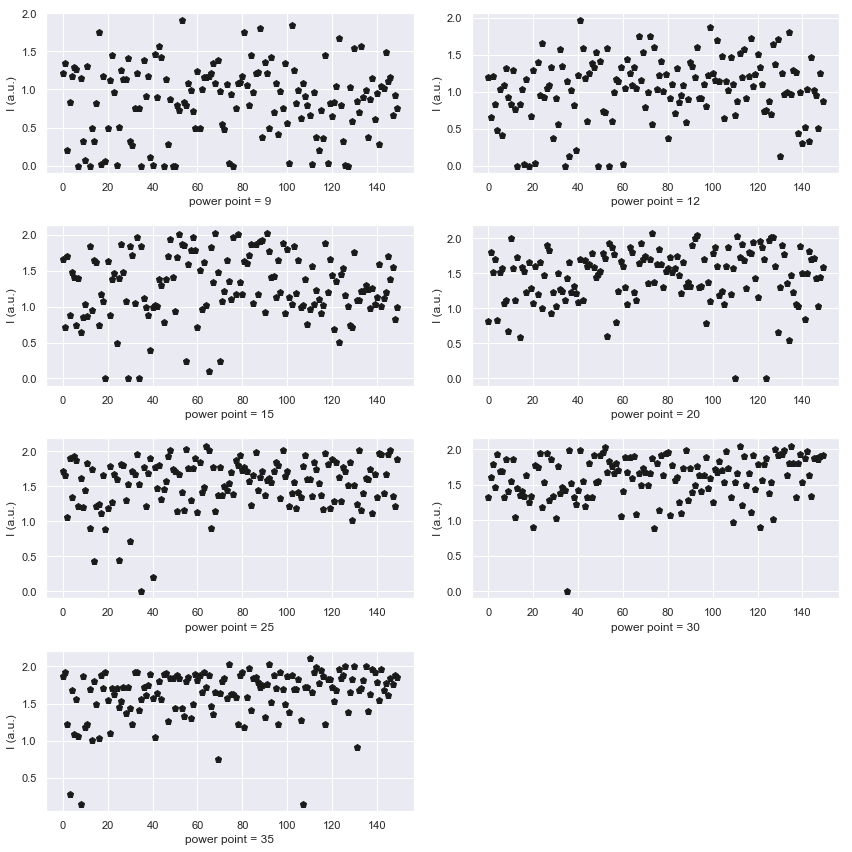

In [525]:
plot_T_series(dftest, T, figsize = (12,12), nx=4, ny=2)

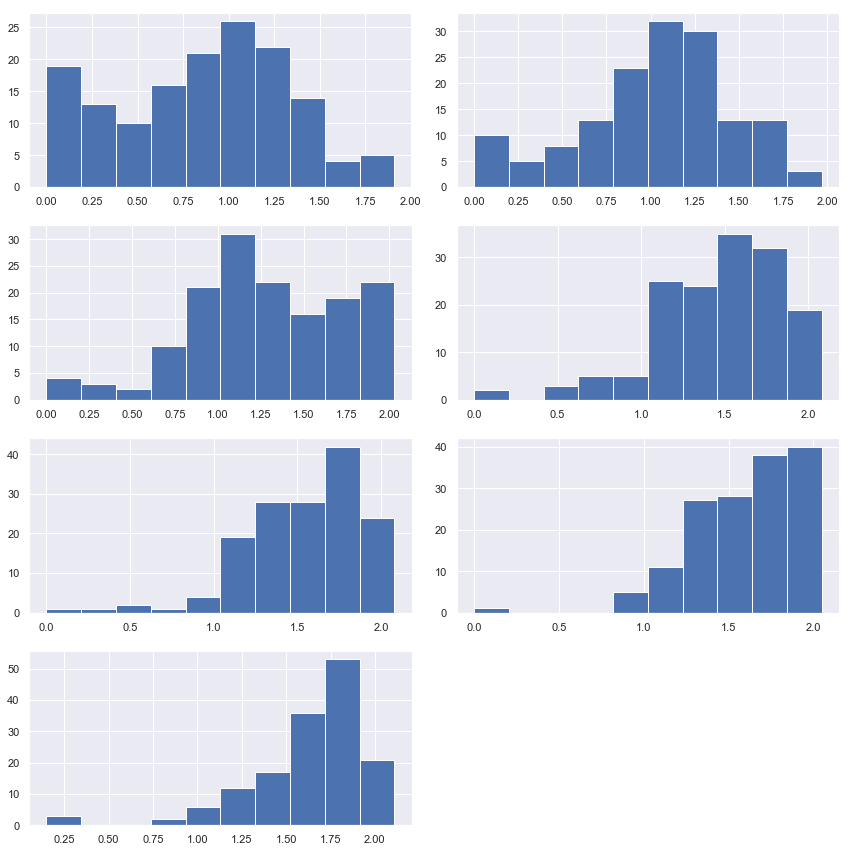

In [526]:
histo_T_series(dftest, figsize = (12,12), nx=4, ny=2)

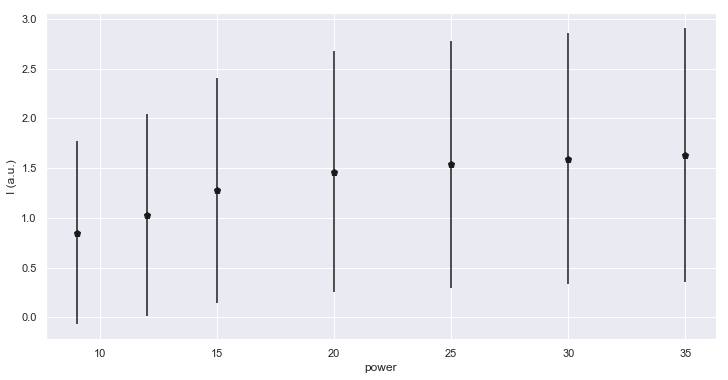

In [527]:
P, Is, Ie = plot_P_series_from_df(dftest, stat = 'mean', thr = -100, figsize = (12,6))

In [385]:
print(f'I vector, average, no threshold = {I}')

I vector, average, no threshold = [0.851      1.0292     1.27813333 1.46426667 1.53826667 1.59473333
 1.63106667]


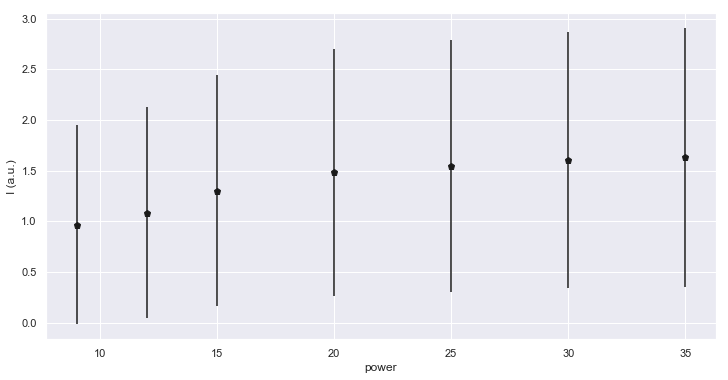

I vector, average, threshold (0.1) = [0.851      1.0292     1.27813333 1.46426667 1.53826667 1.59473333
 1.63106667]


In [387]:
thr = 0.1
P, Is, Ie = plot_P_series_from_df(dftest, stat = 'mean', thr = thr, figsize = (12,6))
print(f'I vector, average, threshold ({thr}) = {I}')

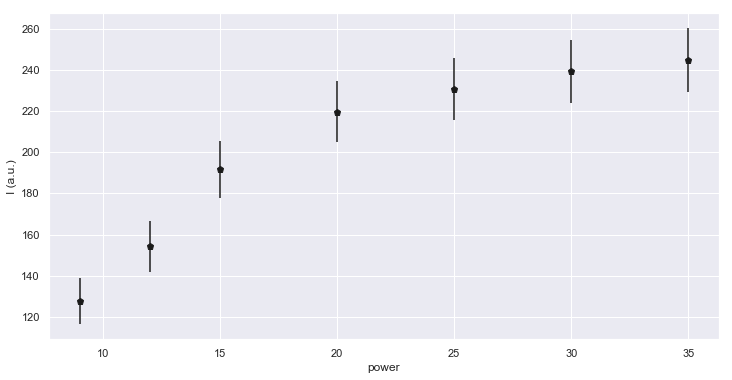

I vector, sum, no threshold  = [0.851      1.0292     1.27813333 1.46426667 1.53826667 1.59473333
 1.63106667]


In [388]:
P, Is, Ie = plot_P_series_from_df(dftest, stat = 'sum', figsize = (12,6))
print(f'I vector, sum, no threshold  = {I}')

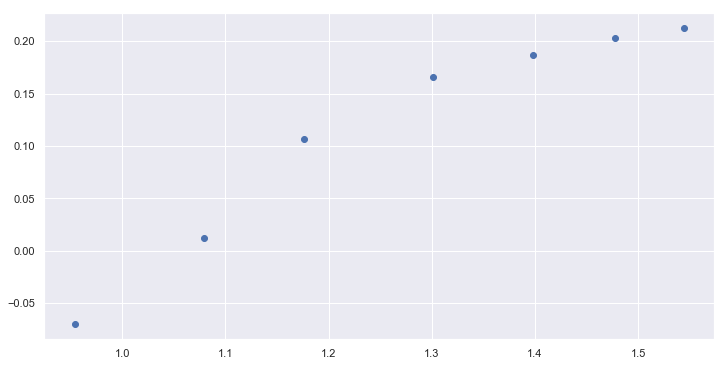

In [528]:
log_fit(P, Is, figsize = (12,6), fit='off', imin=0, imx=(3,6))

2
coefficients of poly fit(0:2): [ 0.78986103 -0.82868845]
3
coefficients of poly fit(0:3): [ 0.70072749 -0.73650931]


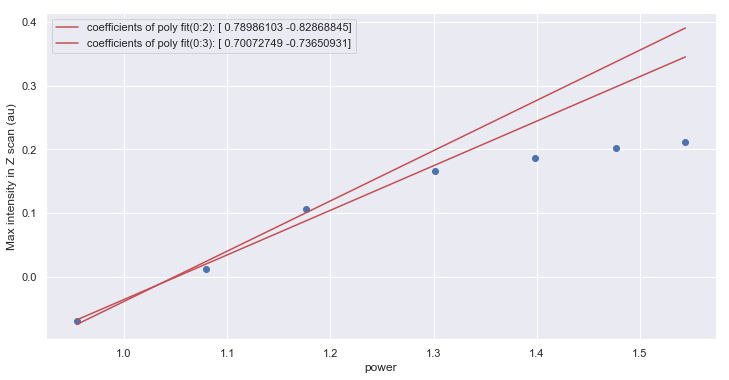

In [530]:
log_fit(P, Is, figsize = (12,6), fit='on', imin=0, imx=(2,4))

### Summary
- power < 1 
- saturation

## 5BA

### Normalization, power 175 mW

In [531]:
filename = os.path.join(path, '5ba_p_175.txt')
dfN5ba = read_xls_files(filename)
dfN5ba.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,-0.0037,-0.0047,1.4946,-0.0047,-0.0043,0.7010,-0.0040,-0.0037,-0.0047,-0.0043,-0.0043,-0.0047
1,-0.0043,-0.0037,-0.0047,-0.0043,-0.0043,-0.0047,-0.0043,-0.0043,0.6521,-0.0040,-0.0047,-0.0043
2,-0.0037,-0.0047,-0.0040,0.1908,-0.0043,-0.0040,-0.0047,-0.0043,-0.0047,-0.0037,-0.0043,-0.0040
3,1.4792,-0.0040,1.4937,-0.0037,-0.0037,0.0005,0.5494,-0.0043,-0.0047,-0.0047,-0.0037,0.4132
4,0.7860,-0.0043,0.7355,-0.0043,0.9200,0.1138,-0.0040,-0.0040,-0.0047,-0.0043,0.1138,0.0678


In [532]:
P = get_power(dfN5ba, opt='str')
T = get_T(dfN5ba)
print(P)
print(T)

['p0' 'p1' 'p2' 'p3' 'p4' 'p5' 'p6' 'p7' 'p8' 'p9' 'p10' 'p11']
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]


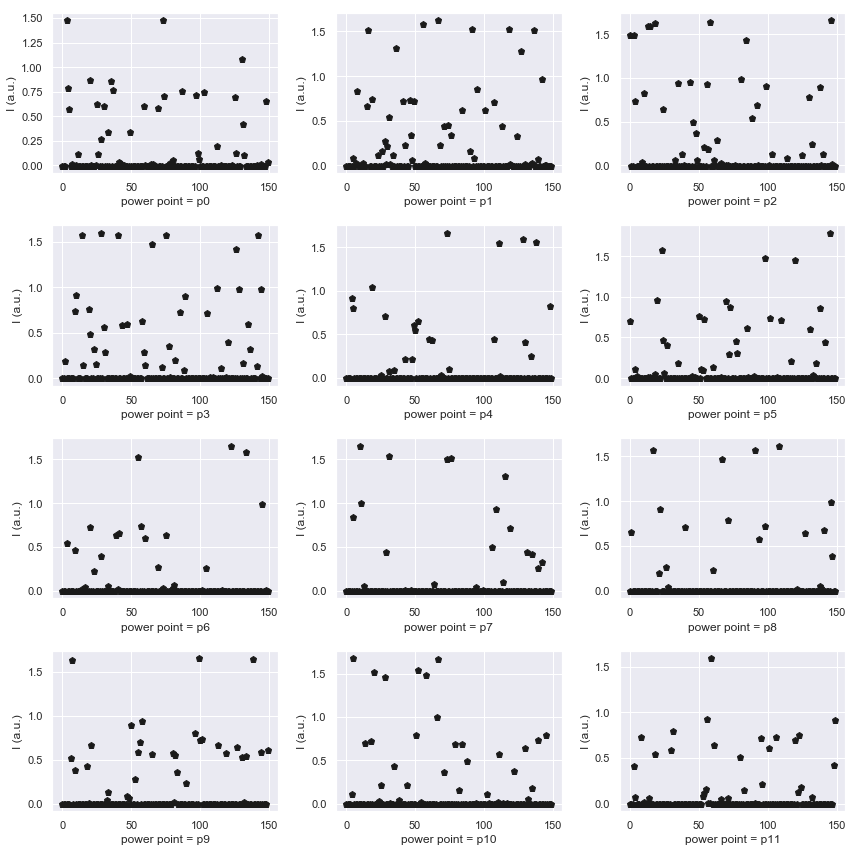

In [535]:
plot_T_series(dfN5ba, T, figsize = (12,12), nx=4, ny=3)

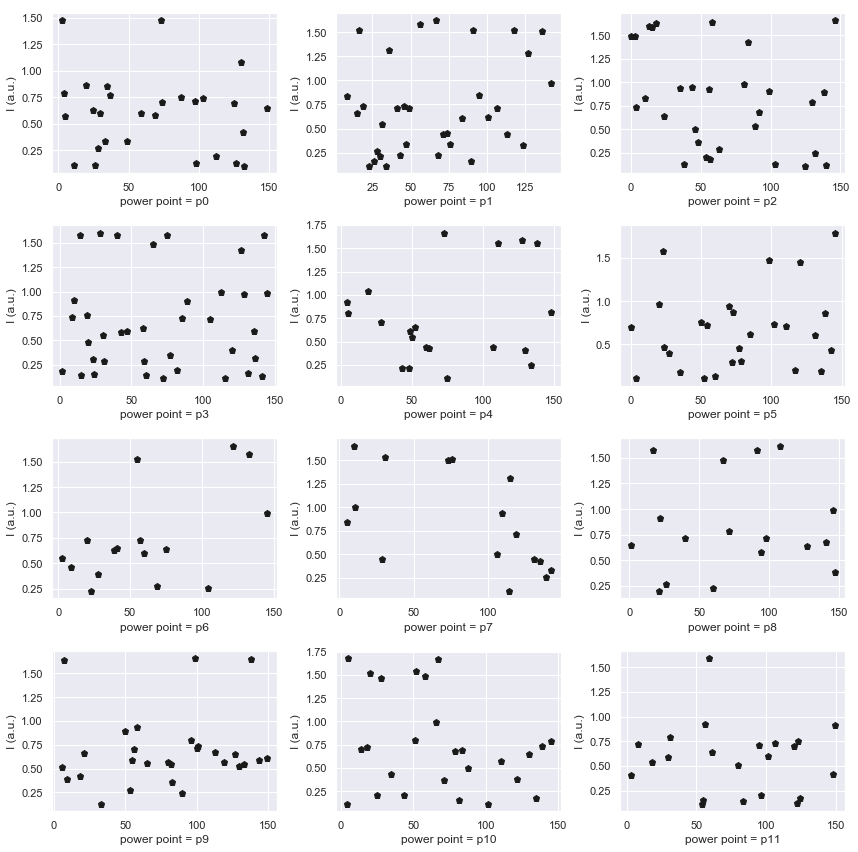

In [536]:
plot_T_series(dfN5ba, T, thr=0.1, figsize = (12,12), nx=4, ny=3)

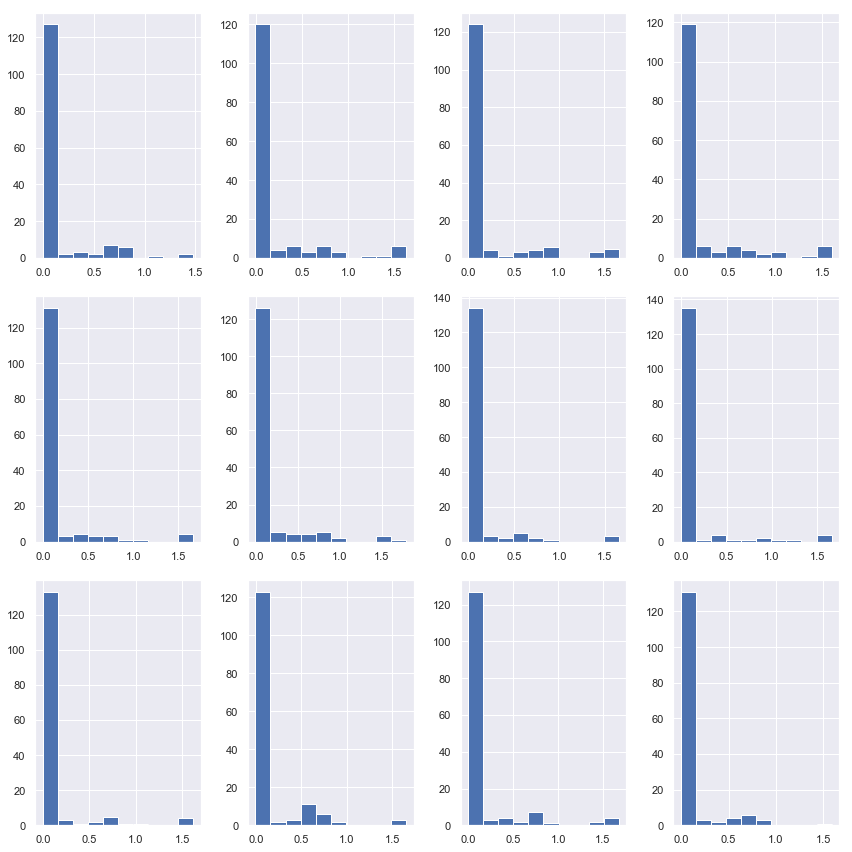

In [537]:
histo_T_series(dfN5ba, figsize = (12,12), nx=3, ny=4)

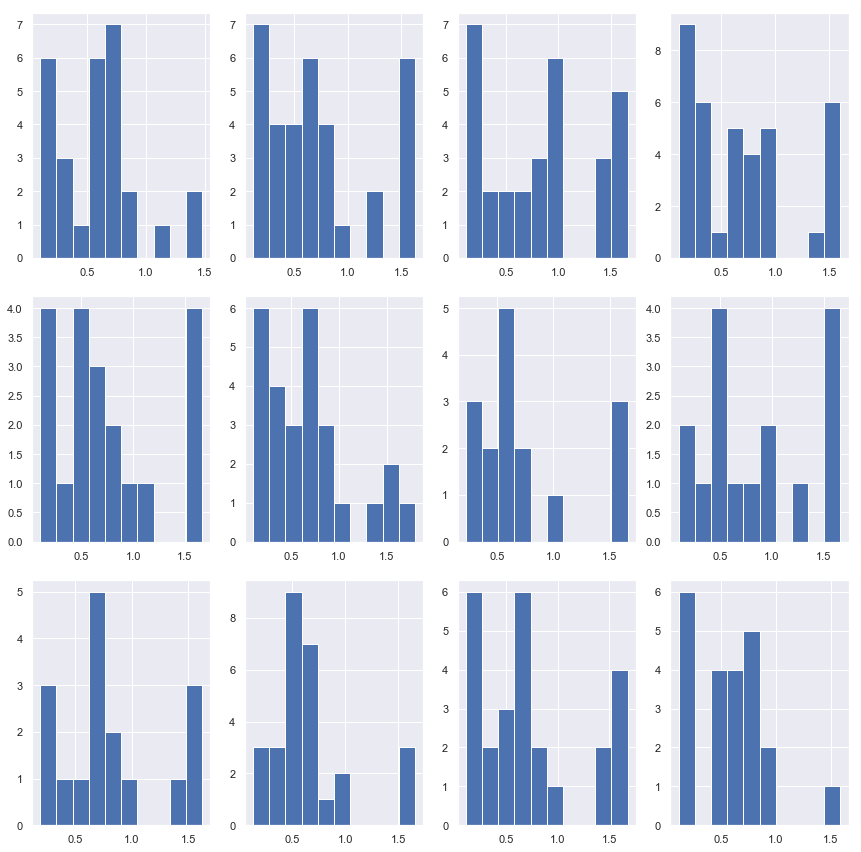

In [426]:
histo_T_series(dfN5ba, thr = 0.1, figsize = (12,12), nx=3, ny=4)

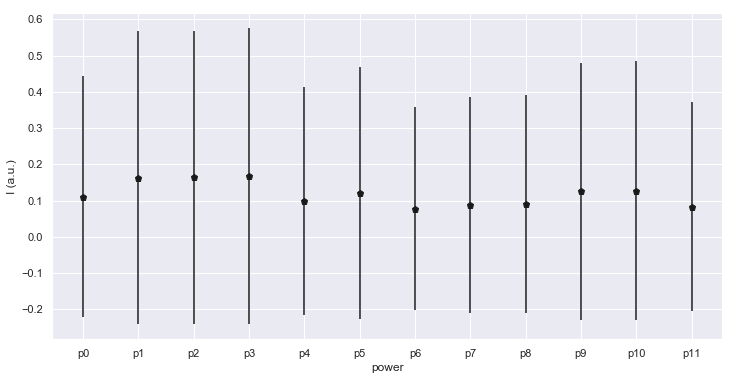

I vector, average, no threshold = [0.110392, 0.16323666666666667, 0.16377599999999998, 0.1672833333333333, 0.09875933333333334, 0.12072266666666664, 0.078132, 0.08838000000000001, 0.09083066666666667, 0.12601666666666667, 0.12723533333333337, 0.08285466666666667]


In [427]:
P, Is, Ie = plot_P_series_from_df(dfN5ba, opt_P = 'str', stat = 'mean', thr = -100, figsize = (12,6))
print(f'I vector, average, no threshold = {Is}')

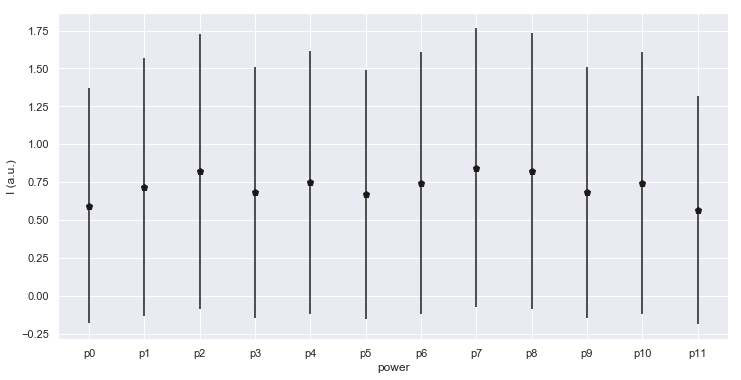

I vector, average, threshold (0.1) = [0.5969642857142857, 0.7187529411764706, 0.8218700000000002, 0.6847540540540541, 0.7509849999999999, 0.6711518518518518, 0.7448187500000001, 0.8466875, 0.8237823529411765, 0.6842035714285714, 0.7446884615384615, 0.5678318181818182]


In [428]:
thr = 0.1
P, Is, Ie = plot_P_series_from_df(dfN5ba, opt_P = 'str', stat = 'mean', thr = thr, figsize = (12,6))
print(f'I vector, average, threshold ({thr}) = {Is}')

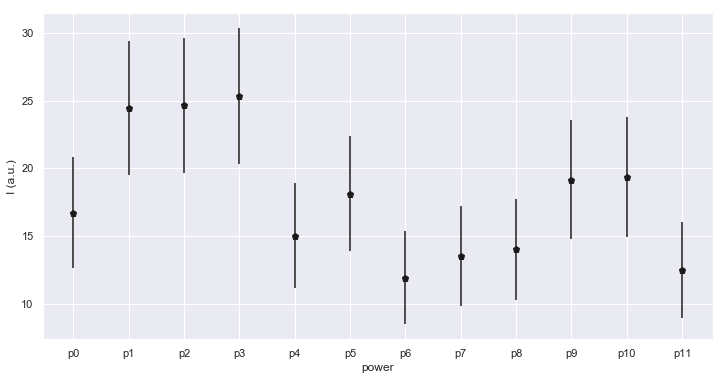

I vector, sum = [16.715, 24.4376, 24.656100000000006, 25.335900000000002, 15.019699999999998, 18.1211, 11.917100000000001, 13.547, 14.0043, 19.1577, 19.3619, 12.4923]


In [538]:
P, Is, Ie = plot_P_series_from_df(dfN5ba, opt_P = 'str', stat = 'sum', thr = thr, figsize = (12,6))
print(f'I vector, sum = {Is}')

### NB: we need to use the sum (the mean of all of them is dominated by zeros) and normalize each point since values vary significantly

In [539]:
Inorm = np.array(Is)

### 5Ba Power scan

In [540]:
filename = os.path.join(path, '5ba_power_scan.txt')
df5ba = read_xls_files(filename)
df5ba.head()

,200,250,300,350,400,450,500,550,600,640,700
0,-0.0040,-0.0031,-0.0040,-0.0047,1.5619,-0.0040,0.8575,-0.0043,0.6029,0.2223,1.0442
1,-0.0037,-0.0043,-0.0040,0.2458,0.0256,0.0536,-0.0002,-0.0037,-0.0047,0.1360,0.0047
2,-0.0047,-0.0037,-0.0040,0.3958,-0.0047,0.3978,0.4087,2.0259,1.0468,0.1544,1.1151
3,-0.0034,-0.0037,-0.0024,0.0011,0.1959,0.2230,1.5674,-0.0005,0.2114,1.6521,0.0098
4,-0.0040,-0.0043,-0.0043,0.2861,-0.0037,1.2506,0.5777,0.6994,1.0529,1.6753,0.8524


In [541]:
P = get_power(df5ba, opt='str')
T = get_T(df5ba)
print(P)
print(T)

['200' '250' '300' '350' '400' '450' '500' '550' '600' '640' '700']
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]


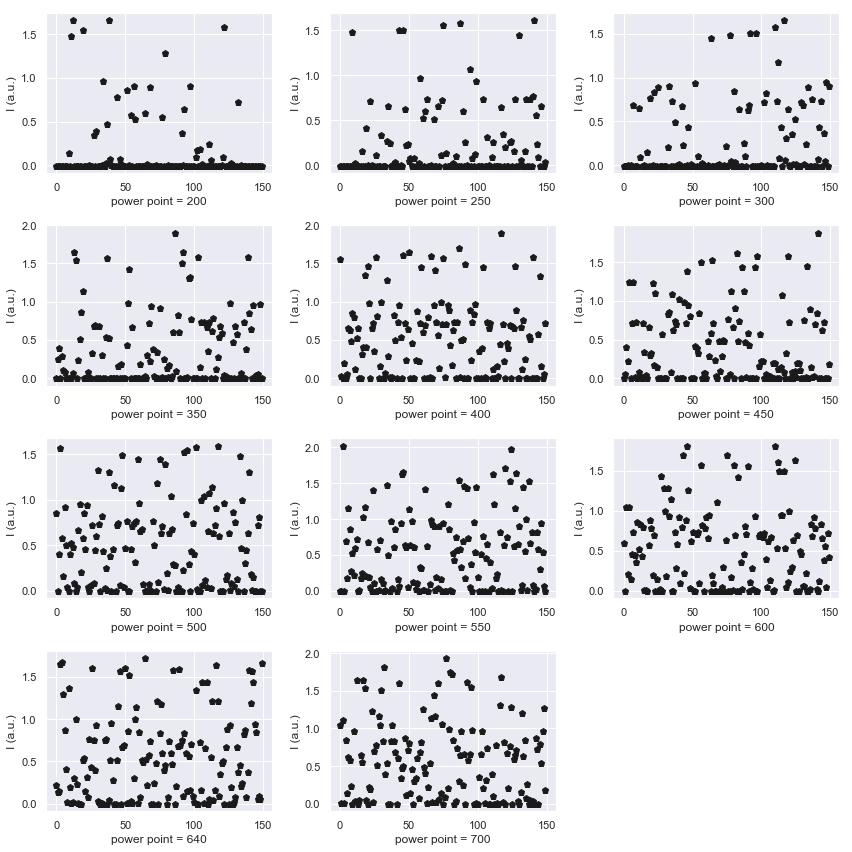

In [542]:
plot_T_series(df5ba, T, figsize = (12,12), nx=4, ny=3)

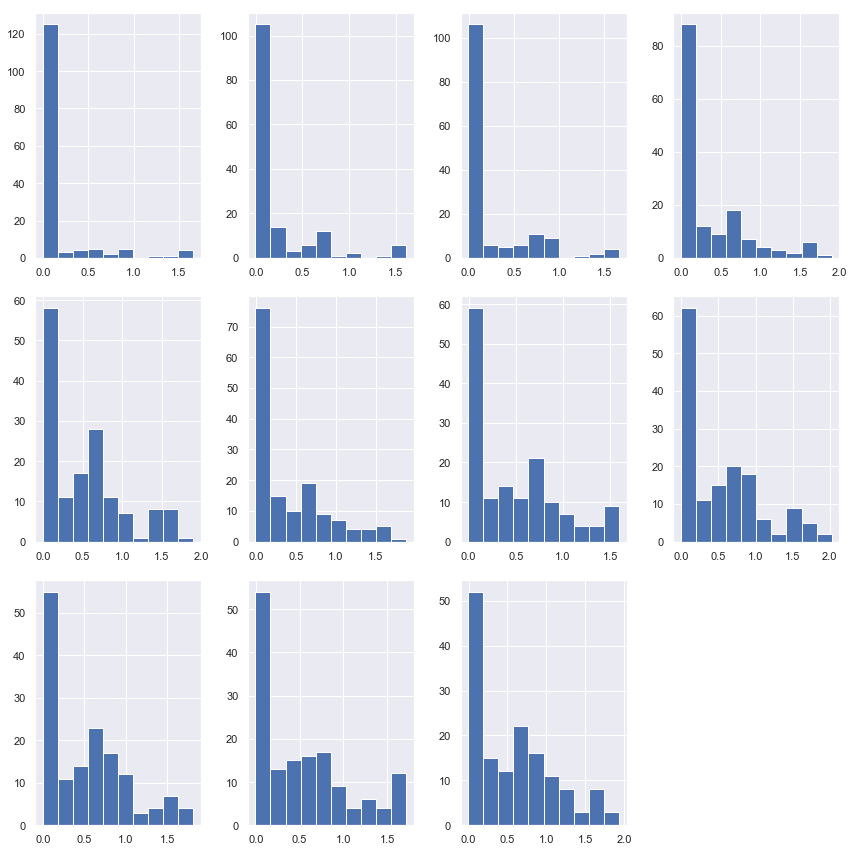

In [543]:
histo_T_series(df5ba, figsize = (12,12), nx=3, ny=4)

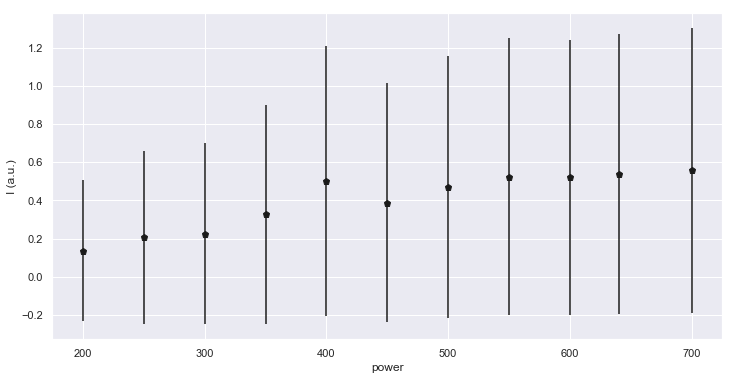

I vector, average, no threshold = [0.13666266666666668, 0.20622266666666664, 0.22663533333333333, 0.32698066666666664, 0.500762, 0.388942, 0.47210133333333326, 0.524474, 0.52049, 0.537352, 0.557048]


In [453]:
P, Is, Ie = plot_P_series_from_df(df5ba, opt_P = 'float', stat = 'mean', thr = -100, figsize = (12,6))
print(f'I vector, average, no threshold = {Is}')

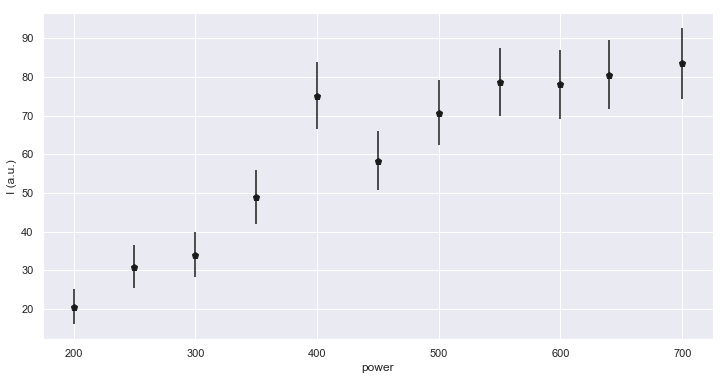

I vector, sum = [20.4994, 30.933399999999995, 33.9953, 49.0471, 75.1143, 58.341300000000004, 70.81519999999999, 78.6711, 78.0735, 80.6028, 83.5572]


In [545]:
P, Is, Ie = plot_P_series_from_df(df5ba, opt_P = 'float', stat = 'sum', thr = -100, figsize = (12,6))
print(f'I vector, sum = {Is}')

In [546]:
Inorm

array([16.715 , 24.4376, 24.6561, 25.3359, 15.0197, 18.1211, 11.9171,
       13.547 , 14.0043, 19.1577, 19.3619, 12.4923])

In [547]:
Inorm[1:len(Inorm)+1]

array([24.4376, 24.6561, 25.3359, 15.0197, 18.1211, 11.9171, 13.547 ,
       14.0043, 19.1577, 19.3619, 12.4923])

In [548]:
Iscan = np.array(Is)
In    = Inorm[1:len(Inorm)+1]
IP = Iscan / In
IPE = np.sqrt(Iscan) / In
print(f'Inorm = {Inorm}')
print(f'Iscan = {Iscan}')
print(f'IP = {IP}')

Inorm = [16.715  24.4376 24.6561 25.3359 15.0197 18.1211 11.9171 13.547  14.0043
 19.1577 19.3619 12.4923]
Iscan = [20.4994 30.9334 33.9953 49.0471 75.1143 58.3413 70.8152 78.6711 78.0735
 80.6028 83.5572]
IP = [0.8388467  1.2545942  1.34178379 3.26551795 4.14512916 4.8955954
 5.22737137 5.61763887 4.07530653 4.16295921 6.68869624]


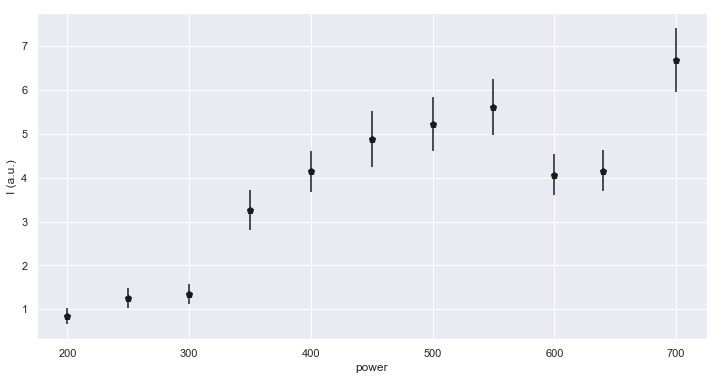

In [550]:
plot_P_series(P, IP, IPE, figsize = (12,6))

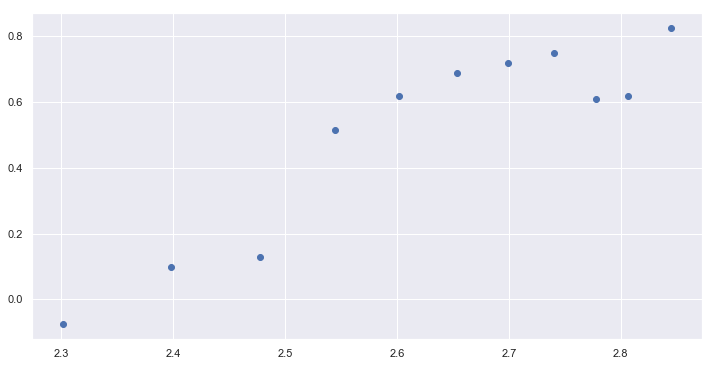

In [551]:
log_fit(P, IP, figsize = (12,6), fit='off', imin=2, imx=(3,8))

4
coefficients of poly fit(0:4): [ 2.3591184  -5.55764314]
5
coefficients of poly fit(0:5): [ 2.33761086 -5.505928  ]
6
coefficients of poly fit(0:6): [ 2.21604862 -5.21112662]


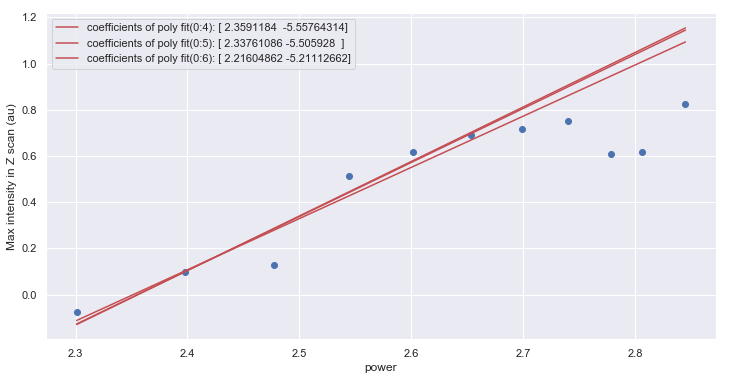

In [554]:
log_fit(P, IP, figsize = (12,6), fit='on', imin=0, imx=(4,7))

### POWER law seems to work!  c = 2!

## FIBA

In [555]:
filename = os.path.join(path, 'fiba_power_scan.txt')
dfa = read_xls_files(filename)
dfa.head()

,20,25,30,35,40,45,50,55,60,65,70,80,90,100
0,0.00,0.00,0.55,0.27,0.69,1.05,0.03,0.73,0.30,1.14,0.07,0.66,0.94,0.40
1,0.00,0.00,0.00,0.00,1.32,0.00,0.66,0.06,0.90,0.00,0.47,1.01,0.00,0.93
2,0.07,0.00,0.00,0.00,0.05,0.52,0.40,0.04,0.04,0.02,0.02,0.41,0.83,1.06
3,0.00,0.11,0.00,0.39,0.91,0.25,1.11,1.32,0.56,1.70,0.59,0.01,0.20,0.30
4,0.00,0.63,0.00,0.10,1.26,0.42,0.59,1.52,0.13,0.77,1.19,1.59,0.07,0.80


In [556]:
P = get_power(dfa, opt='float')
T = get_T(dfa)
print(P)
print(T)

[ 20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  80.  90. 100.]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]


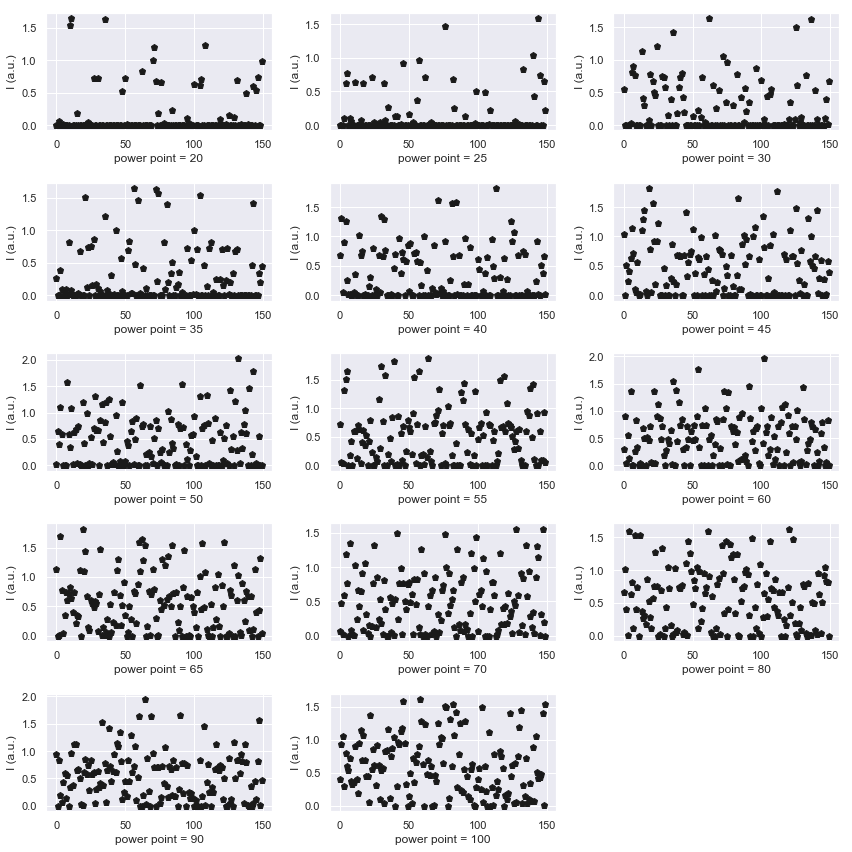

In [557]:
plot_T_series(dfa, T, figsize = (12,12), nx=5, ny=3)

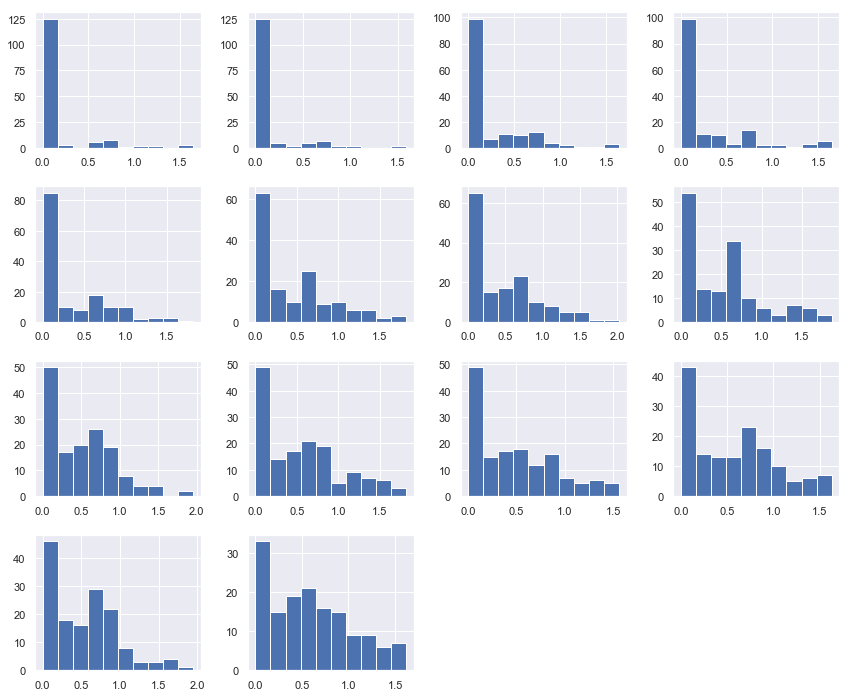

In [558]:
histo_T_series(dfa, figsize = (12,12), nx=5, ny=4)

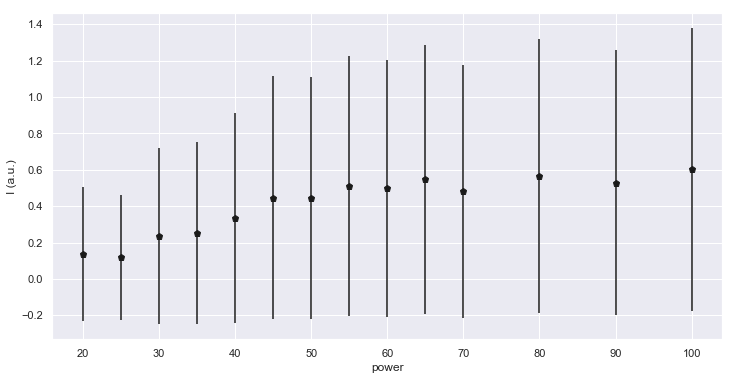

I vector, average, no threshold = [0.13686666666666666, 0.1182, 0.23459999999999998, 0.25106666666666666, 0.3356, 0.4475333333333333, 0.44439999999999996, 0.5122000000000001, 0.49759999999999993, 0.5470666666666667, 0.48106666666666664, 0.5669333333333333, 0.5302, 0.6032]


In [466]:
P, Is, Ie = plot_P_series_from_df(dfa, opt_P = 'float', stat = 'mean', thr = -100, figsize = (12,6))
print(f'I vector, average, no threshold = {Is}')

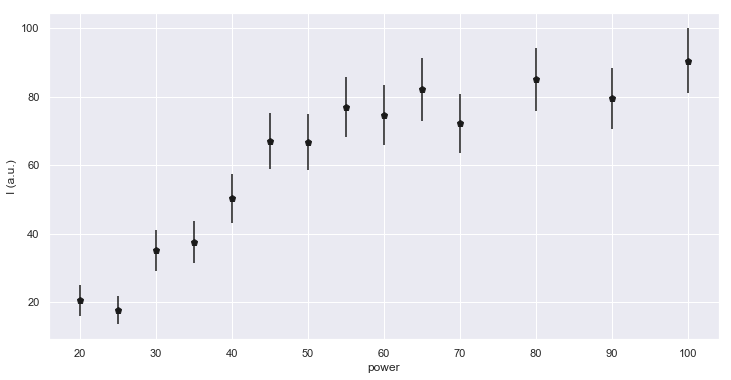

I vector, sum = [20.53, 17.73, 35.19, 37.66, 50.34, 67.13, 66.66, 76.83000000000001, 74.63999999999999, 82.06, 72.16, 85.03999999999999, 79.53, 90.47999999999999]


In [562]:
P, Is, Ie = plot_P_series_from_df(dfa, opt_P = 'float', stat = 'sum', thr = -100, figsize = (12,6))
print(f'I vector, sum = {Is}')

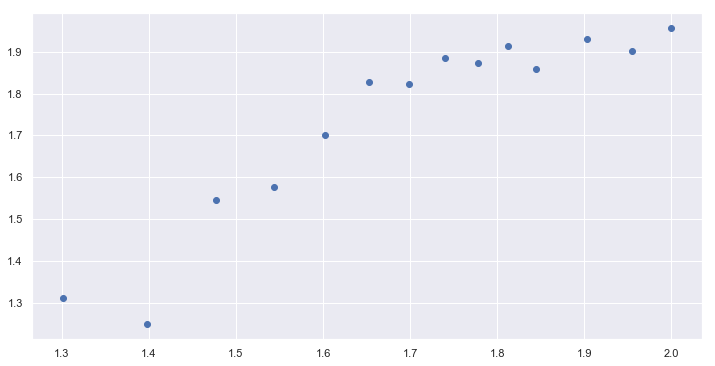

In [563]:
log_fit(P, Is, figsize = (12,6), fit='off', imin=2, imx=(3,8))

3
coefficients of poly fit(1:3): [ 2.28483037 -1.90865085]
4
coefficients of poly fit(1:4): [ 2.07669847 -1.60781827]
5
coefficients of poly fit(1:5): [ 2.08109285 -1.61426092]


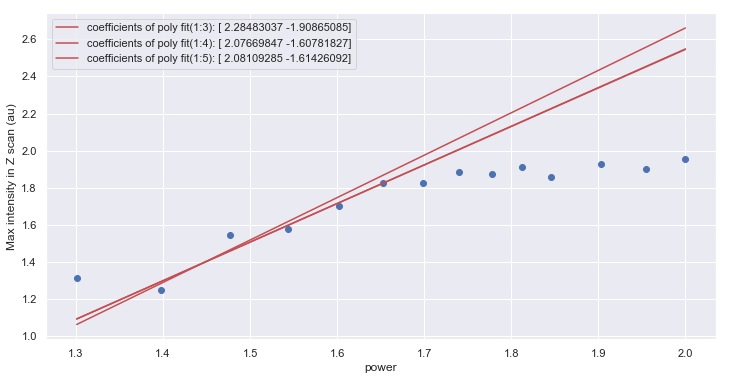

In [567]:
log_fit(P, Is, figsize = (12,6), fit='on', imin=1, imx=(3,6))

### Except for one point, power 2... and saturation. 

## FIBc

In [497]:
filename = os.path.join(path, 'fibc_norm.txt')
dfcn = read_xls_files(filename)
dfcn.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
0,0.7204,0.2217,-0.0053,0.0797,-0.0053,-0.0047,0.0053,0.3060,-0.0053,-0.0056
1,-0.0053,-0.0050,-0.0056,-0.0047,-0.0053,-0.0050,-0.0053,0.7477,-0.0053,0.0021
2,-0.0050,-0.0053,-0.0056,0.7377,-0.0008,0.0069,-0.0063,-0.0056,-0.0056,-0.0050
3,-0.0002,1.5674,-0.0056,-0.0053,-0.0050,0.5220,-0.0059,-0.0047,0.0121,-0.0053
4,-0.0056,-0.0050,-0.0053,-0.0059,0.0076,-0.0050,-0.0050,-0.0050,0.0237,-0.0053


In [498]:
P = get_power(dfcn, opt='str')
T = get_T(dfcn)
print(P)
print(T)

['p0' 'p1' 'p2' 'p3' 'p4' 'p5' 'p6' 'p7' 'p8' 'p9']
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]


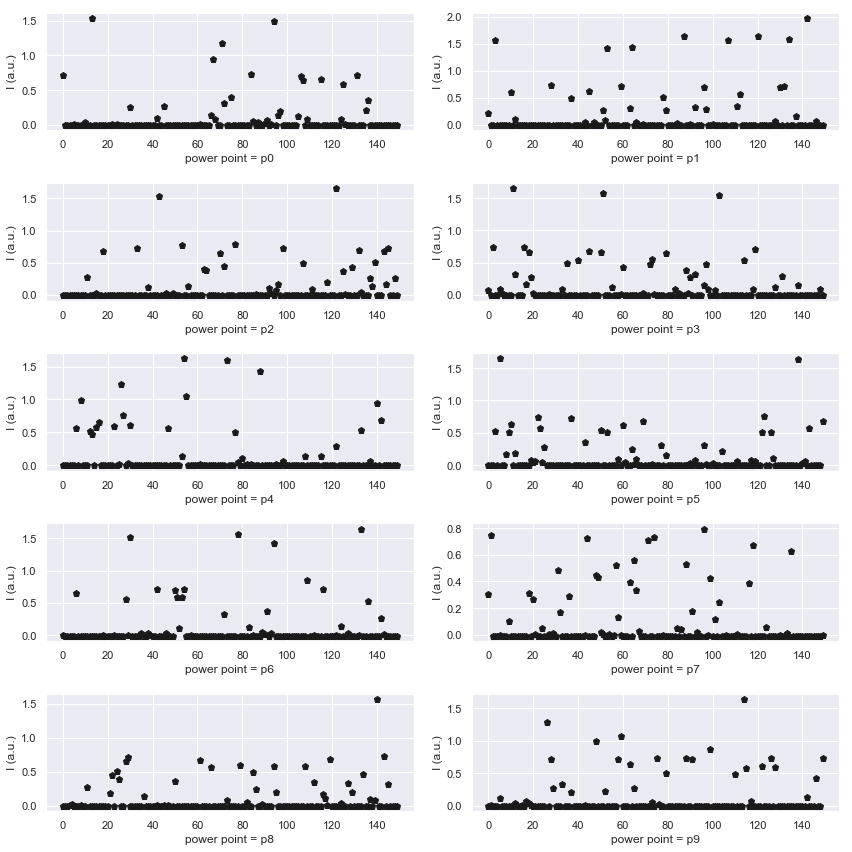

In [499]:
plot_T_series(dfcn, T, thr=-100, figsize = (12,12), nx=5, ny=2)

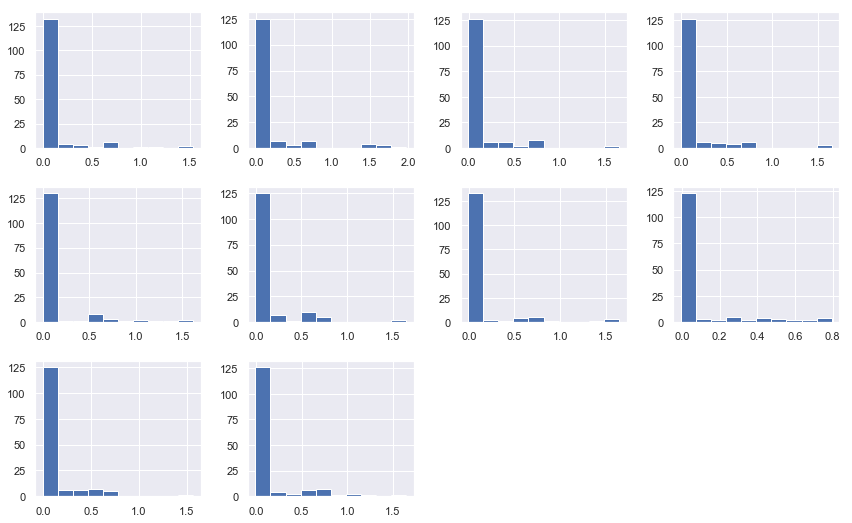

In [500]:
histo_T_series(dfcn, figsize = (12,12), nx=5, ny=4)

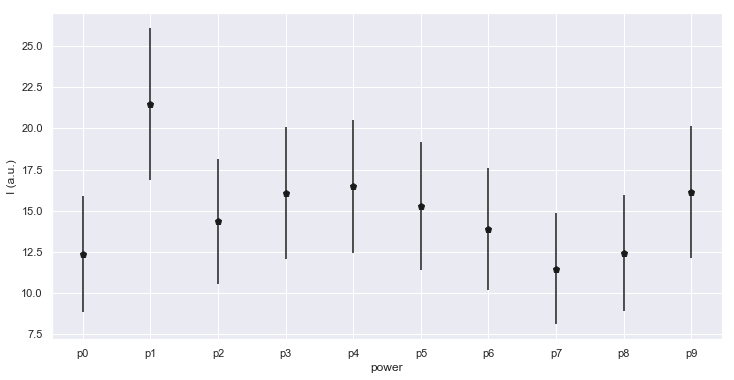

I vector, sum = [12.364899999999999, 21.471799999999995, 14.3558, 16.0766, 16.4789, 15.277600000000003, 13.877500000000001, 11.4659, 12.4123, 16.1329]


In [503]:
P, Is, Ie = plot_P_series_from_df(dfcn, opt_P = 'str', stat = 'sum', thr = -100, figsize = (12,6))
print(f'I vector, sum = {Is}')

In [504]:
Inorm = np.array(Is)

In [505]:
filename = os.path.join(path, 'fibc_power_scan.txt')
dfc = read_xls_files(filename)
dfc.head()

,50,60,70,80,90,100,110,120,130
0,-0.0056,0.1949,-0.0050,0.0794,0.2703,0.2300,0.6566,1.2500,0.6808
1,-0.0053,0.0626,-0.0059,-0.0050,0.0073,0.0208,0.0198,0.4300,0.3817
2,-0.0050,0.1103,1.5758,0.0475,0.4210,0.5623,0.2928,0.4052,0.2339
3,-0.0047,0.0514,-0.0043,0.5726,-0.0050,0.0121,-0.0047,-0.0053,0.2503
4,1.5529,0.3727,0.5784,0.7413,1.5526,1.5542,0.2490,0.1299,0.4110


In [508]:
P = get_power(dfc, opt='float')
T = get_T(dfcn)
print(P)
print(T)

[ 50.  60.  70.  80.  90. 100. 110. 120. 130.]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]


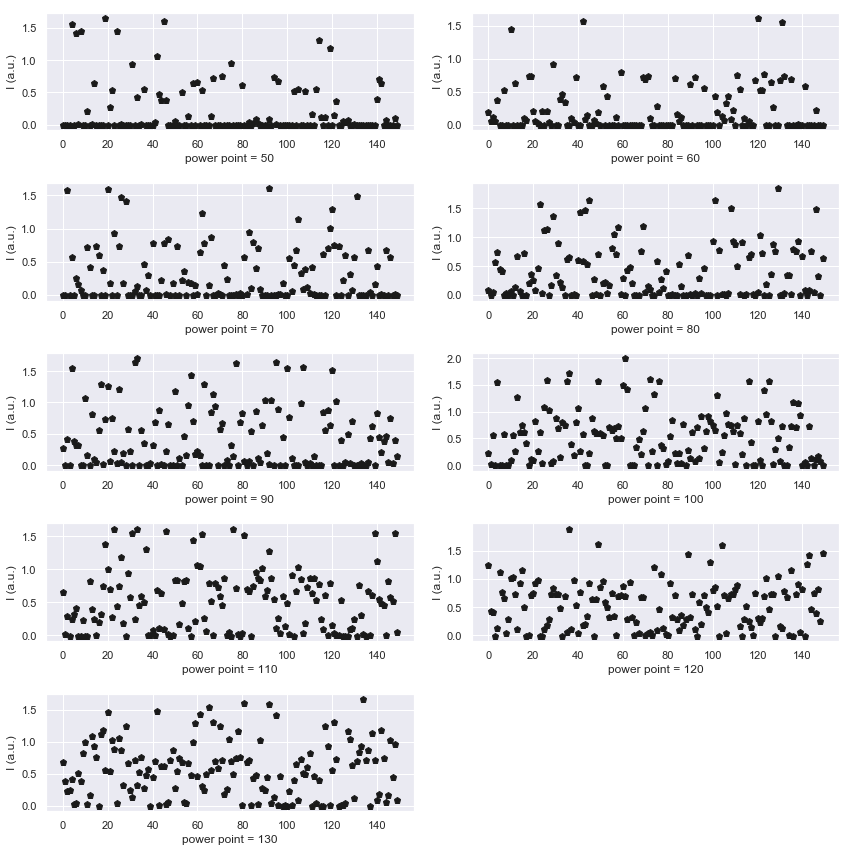

In [509]:
plot_T_series(dfc, T, thr=-100, figsize = (12,12), nx=5, ny=2)

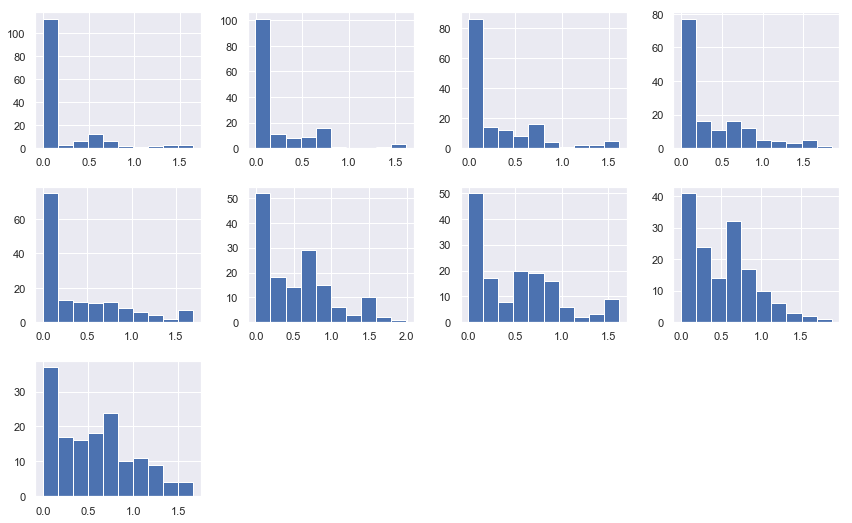

In [510]:
histo_T_series(dfc, figsize = (12,12), nx=5, ny=4)

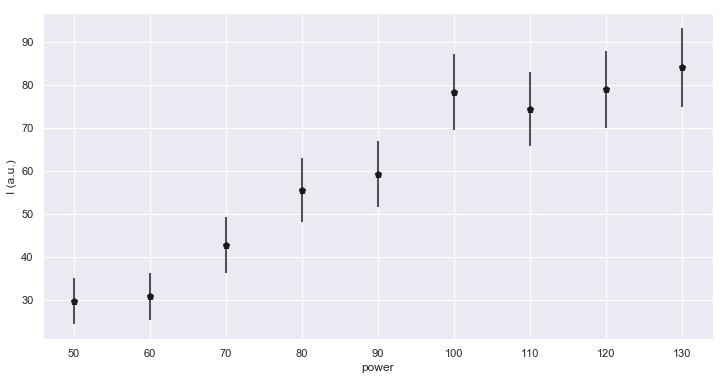

I vector, sum = [29.703, 30.815999999999995, 42.7453, 55.597300000000004, 59.327, 78.47720000000001, 74.463, 79.0332, 84.1963]


In [511]:
P, Is, Ie = plot_P_series_from_df(dfc, opt_P = 'float', stat = 'sum', thr = -100, figsize = (12,6))
print(f'I vector, sum = {Is}')

In [512]:
Iscan = np.array(Is)
In    = Inorm[1:len(Inorm)+1]
IP = Iscan / In
IPE = np.sqrt(Iscan) / In
print(f'Inorm = {Inorm}')
print(f'Iscan = {Iscan}')
print(f'IP = {IP}')

Inorm = [12.3649 21.4718 14.3558 16.0766 16.4789 15.2776 13.8775 11.4659 12.4123
 16.1329]
Iscan = [29.703  30.816  42.7453 55.5973 59.327  78.4772 74.463  79.0332 84.1963]
IP = [1.38334932 2.14658884 2.658852   3.37384777 3.88326701 5.6549955
 6.49430049 6.36732918 5.2189191 ]


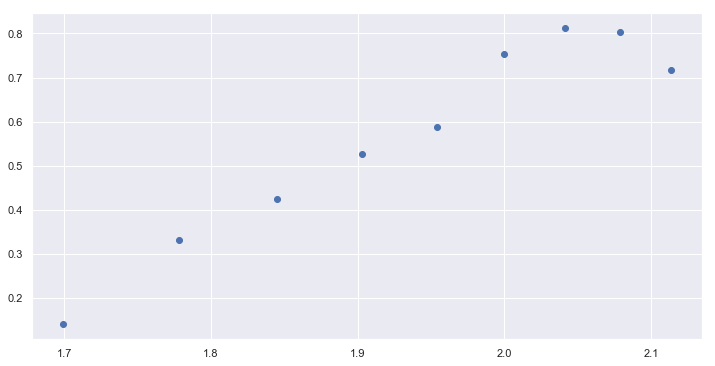

In [513]:
log_fit(P, IP, figsize = (12,6), fit='off', imin=2, imx=(3,8))

1
coefficients of poly fit(0:1): [ 2.40987625 -3.9533756 ]
2
coefficients of poly fit(0:2): [ 1.95599602 -3.17095496]
3
coefficients of poly fit(0:3): [ 1.85852248 -3.00072484]
4
coefficients of poly fit(0:4): [ 1.73613988 -2.78445767]
5
coefficients of poly fit(0:5): [ 1.8760948  -3.03446152]
6
coefficients of poly fit(0:6): [ 1.90508136 -3.08675894]


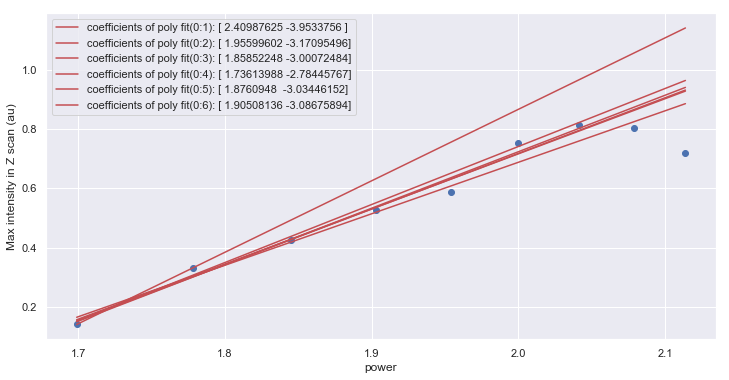

In [514]:
log_fit(P, IP, figsize = (12,6), fit='on', imin=0, imx=(1,7))

6
coefficients of poly fit(0:6): [ 1.90508136 -3.08675894]


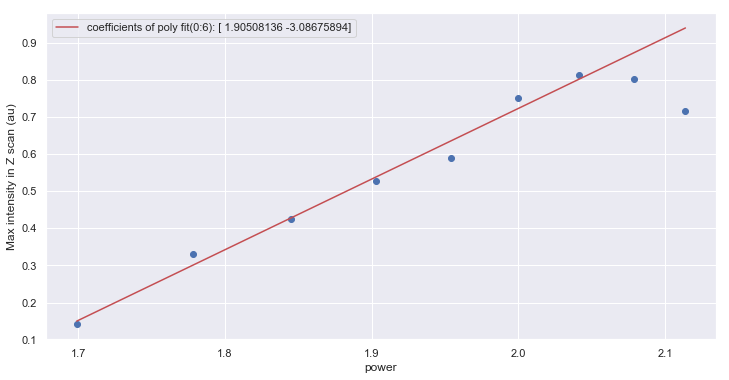

In [516]:
log_fit(P, IP, figsize = (12,6), fit='on', imin=0, imx=(6,7))

### Power law of n=2 up to saturation!